# Example with ERA5 high-resolution (~0.25deg) monthly means


# Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#data_wrangling">2. Data Wrangling</a></li>
<li><a href="#exploratory">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusion">4. Conclusion</a></li>
<li><a href="#references">5. References</a></li>
</ul>

# 1. Introduction <a id='introduction'></a>
Cloud feedbacks are a major contributor to the spread of climate sensitivity in global climate models (GCMs) ([Zelinka et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019GL085782)]). Among the most poorly understood cloud feedbacks is the one associated with the cloud phase, which is expected to be modified with climate change ([Bjordal et al. (2020)](https://doi-org.ezproxy.uio.no/10.1038/s41561-020-00649-1)). Cloud phase bias, in addition, has significant implications for the simulation of radiative properties and glacier and ice sheet mass balances in climate models. 

In this context, this work aims to expand our knowledge on how the representation of the cloud phase affects snow formation in GCMs. Better understanding this aspect is necessary to develop climate models further and improve future climate predictions. 

* Load ERA5 data previously downloaded locally via [Jupyter Notebook - download ERA5](https://github.com/franzihe/download_ERA5)
* find clouds: liquid-only, ice-only, mixed-phase
* Regridd the ERA5 variables to the same horizontal resolution as high-resolution CMIP6 models with [`xesmf`](https://xesmf.readthedocs.io/en/latest/)
* Calculate and plot the seasonal mean of the variable

**Questions**
* How is the cloud phase and snowfall varying between 1985 and 2014?


> **_NOTE:_** We answer questions related to the comparison of CMIP models to ERA5 in another [Jupyter Notebook](../CMIP6_ERA5_CloudSat/plt_seasonal_mean.ipynb).

# 2. Data Wrangling <a id='data_wrangling'></a>

This study will compare surface snowfall, ice, and liquid water content from the Coupled Model Intercomparison Project Phase 6 ([CMIP6](https://esgf-node.llnl.gov/projects/cmip6/)) climate models (accessed through [Pangeo](https://pangeo.io/)) to the European Centre for Medium-Range Weather Forecast Re-Analysis 5 ([ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)) data from **1985 to 2014**. We conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) in the CMIP6 models and their potential connection between them. The CMIP6 data analysis can be found in the [Jupyter Notebook for CMIP6](../cmip/CMIP6_hr_1985-2014.ipynb).

- Time period: 1985 to 2014
- horizonal resolution: ~0.25deg
- time resolution: monthly atmospheric data 
- Variables:
  
| shortname     |             Long name                   |      Units    |  levels |
| ------------- |:---------------------------------------:| -------------:|--------:|
| sf            |    snowfall                             |[m of water eq]| surface |
| msr           |    mean_snowfall_rate                   |[kg m-2 s-1]   | surface |
| cswc          |    specific_snow_water_content          | [kg kg-1]     |    pl   |
| clwc          |    specific_cloud_liquid_water_content  |   [kg kg-1]   |    pl   |
| clic          |    specific_cloud_ice_water_content     | [kg kg-1]     |    pl   |
| t             |    temperature                          |  [K]          |    pl   |
| 2t            |    2 metre temperature                  |  [K]          | surface |
| tclw          |   Total column cloud liquid water       |  [kg m-2]     | single  |
| tciw          |   Total column cloud ice water          |  [kg m-2]     | single  |
| tp            |   Total precipitation                   |  [m]          | surface |


## Import python packages
- `Python` environment requirements: file [globalsnow.yml](../globalsnow.yml) 
- load `python` packages from [imports.py](../utils/imports.py)
- load `functions` from [functions.py](../utils/functions.py)

In [1]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
import sys
import os
if os.path.isfile('/uio/kant/geo-metos-u1/franzihe/Documents/Python/globalsnow/eosc-nordic-climate-demonstrator/work/utils/imports.py') == True:
    sys.path.append('/uio/kant/geo-metos-u1/franzihe/Documents/Python/globalsnow/eosc-nordic-climate-demonstrator/work/utils')
    
elif os.path.isfile('/uio/kant/geo-metos-u1/franzihe/Documents/Python/globalsnow/eosc-nordic-climate-demonstrator/work/utils/imports.py') == False:
    sys.path.append('/home/franzihe/Documents/Python/eosc-nordic-climate-demonstrator/work/utils/')

from imports import(xr, intake, ccrs, cy, plt, glob, cm, fct, np, da)
xr.set_options(display_style='html')

In [2]:
# reload imports
%load_ext autoreload
%autoreload 2

## Open ERA5 variables
Get the data requried for the analysis. Beforehand we downloaded the monthly averaged data on single levels and pressure levels via the Climate Data Store (CDS) infrastructure. The github repository [Download ERA5](https://github.com/franzihe/download_ERA5) gives examples on how to download the data from the CDS. We use the Jupyter Notebooks [download_Amon_single_level](https://github.com/franzihe/download_ERA5/blob/main/download_Amon_single_level.ipynb) and [download_Amon_pressure_level](https://github.com/franzihe/download_ERA5/blob/main/download_Amon_pressure_level.ipynb). Both, download the monthly means for the variables mentioned above between 1985 and 2014.

> **_NOTE:_** To download from CDS a user has to have a CDS user account, please create the account [here](https://cds.climate.copernicus.eu/user/register).


The ERA5 0.25deg data is located in the folder `/input/ERA5/monthly_means/0.25deg`.


In [3]:
if (len(glob('/scratch/franzihe/input/ERA5/monthly_means/0.25deg/*_Amon_ERA5_*12.nc')) > 0) == True:
    input_data = '/scratch/franzihe/input'
    output_data = '/scratch/franzihe/output'

if (len(glob('/home/franzihe/Data/input/ERA5/monthly_means/0.25deg/*_Amon_ERA5_*12.nc')) > 0) == True:
    input_data = '/home/franzihe/Data/input/'
    output_data = '/home/franzihe/Data/output'


In [4]:
era_in = '{}/ERA5/monthly_means/0.25deg'.format(input_data)
era_out = '{}/ERA5/monthly_means/1deg'.format(output_data)

In [11]:
variable_id=[
            '2t',
            'clic',
            'clwc',
            'cswc',
            'msr',
            'sf',
            't', 
            'tciw',
            'tclw',
            'tp'
             ]

At the moment we have downloaded 30 years (1985-2014) for ERA5. We define start and end year to ensure to only extract the 30-year period between 1985 and 2014.

$\rightarrow$ Define a start and end year

We will load all available variables into one xarray dataset with `xarray.open_mfdataset(file)` and select the time range [by name](https://xarray.pydata.org/en/stable/user-guide/indexing.html).

In [6]:
starty = 1985; endy = 2014
year_range = range(starty, endy+1)
# Input data from ERA5 with a resolution of 0.25x0.25deg to be regridded
era_file_in = glob('{}/*_Amon_ERA5_*12.nc'.format(era_in, ))       # search for data in the local directory 
ds_era = xr.open_mfdataset(era_file_in)
ds_era = ds_era.sel(time = ds_era.time.dt.year.isin(year_range)).squeeze()


## Change attributes matching CMIP6 data

We will assign the attributes to the variables to make CMIP6 and ERA5 variables comperable.

The data [documentation of monthly means](https://confluence.ecmwf.int/pages/viewpage.action?pageId=82870405#ERA5:datadocumentation-Monthlymeans) gives information about the accumulations in monthly means (of daily means, stream=moda/edmo). Hence, the precipitation variables have been scaled to have an "effective" processing period of one day, so for accumulations in these streams
* [`sf`](https://apps.ecmwf.int/codes/grib/param-db?id=144) is in **m of water per day** $\rightarrow$  multiply by **1000** to get **kg m-2 day-1** or **mmday-1**.


* [`tp`](https://apps.ecmwf.int/codes/grib/param-db?id=228) is in **m** $\rightarrow$ Multiply by **1000** to get **mm**
* [`ciwc`](https://apps.ecmwf.int/codes/grib/param-db?id=247), [`clwc`](https://apps.ecmwf.int/codes/grib/param-db?id=246), and [`cswc`](https://apps.ecmwf.int/codes/grib/param-db?id=76) is in **kg kg-1**    $\rightarrow$ Multiply by **1000** to get **g kg-1**
* [`msr`](https://apps.ecmwf.int/codes/grib/param-db?id=235031) is in **kg m-2 s-1** $\rightarrow$ Multiply by **86400** to get **mm day-1**
* [`tciw`](https://apps.ecmwf.int/codes/grib/param-db?id=79) and [`tclw`](https://apps.ecmwf.int/codes/grib/param-db?id=78) is in **kg m-2** $\rightarrow$ Multiply by **1000** to get **g m-2**


In [12]:
# rename variable name to variable id
variable_id[variable_id.index('2t')] = 't2m'
variable_id[variable_id.index('clic')] = 'ciwc'


['t2m', 'ciwc', 'clwc', 'cswc', 'msr', 'sf', 't', 'tciw', 'tclw', 'tp']

In [13]:
for var_id in variable_id:
    
    if var_id == 'ciwc' or var_id == 'clwc' or var_id == 'cswc' or var_id == 'sf' or var_id == 'tciw' or var_id == 'tclw' or var_id == 'tp':
        ds_era[var_id] = ds_era[var_id]*1000
        
        if var_id == 'ciwc':
            ds_era[var_id].attrs = {'units': 'g kg-1', 'long_name':'Specific cloud ice water content'}
        if var_id == 'clwc':
            ds_era[var_id].attrs = {'units': 'g kg-1', 'long_name':'Specific cloud liquid water content'}
        if var_id == 'cswc':
            ds_era[var_id].attrs = {'units': 'g kg-1', 'long_name':'Specific snow water content'}
        if var_id == 'sf':
            ds_era[var_id].attrs = {'units': 'mm day-1', 'long_name': 'Snowfall',}
        if var_id == 'tciw':
            ds_era[var_id].attrs = {'units': 'g m-2', 'long_name': 'Total column cloud ice water'}
        if var_id == 'tclw':
            ds_era[var_id].attrs = {'units': 'g m-2', 'long_name': 'Total column cloud liquid water'}
        if var_id == 'tp':
            ds_era[var_id].attrs = {'units': 'mm', 'long_name': 'Total precipitation'}
        
    if var_id == 'msr':
        ds_era[var_id] = ds_era[var_id]*86400
        ds_era[var_id].attrs = {'units': 'mm day-1', 'long_name': 'Mean snowfall rate'}

## Find mixed-phase clouds

To get a relationship between cloud phase and snowfall amount we find mixed-phase clouds and associated precipitation in each grid cell. $\rightarrow$ 

1. loop through each latitude
2. loop through each longitude
3. calculate percentages in each level
   1. IWC + LWC = 100%
   2. IWC/(IWC + LWC) * 100 = percent_iwc %
   3. LWC/(IWC + LWC) * 100 = percent_lwc %
4. level where percent_iwc == 50% and percent_lwc == 50%
   1. P(percent_iwc == 50% and percent_lwc == 50%)
   2. T(percent_iwc == 50% and percent_lwc == 50%)
   3. IWC(percent_iwc == 50% and percent_lwc == 50%)
   4. LWC(percent_iwc == 50% and percent_lwc == 50%)
   5. SWC(percent_iwc == 50% and percent_lwc == 50%)
   6. sf(percent_iwc == 50% and percent_lwc == 50%)
   7. tp(percent_iwc == 50% and percent_lwc == 50%)

1. find, where precipitation is >= 0.25 mm day-1 and IWC+LWC >= 0.01 g kg-1


In [15]:
# 3. calculate percentages in each level 
# 3.1. IWC + LWC = 100%
ds_era['ciwc_clwc'] = ds_era['ciwc'] + ds_era['clwc']

In [16]:
# 3.2. IWC/(IWC + LWC)  = percent_iwc 
ds_era['ciwc_percent'] = ds_era['ciwc']/ds_era['ciwc_clwc']

# 3.3. LWC/(IWC + LWC)  = percent_lwc 
ds_era['clwc_percent'] = ds_era['clwc']/ds_era['ciwc_clwc']

In [17]:
# create pressure array 
ds_era['pressure'] = xr.DataArray(data=da.ones(shape = ds_era['clwc'].shape, chunks=(120, 37, 721, 1440/2)), 
                                                               dims=list(ds_era['clwc'].dims), 
                                                               coords=[ds_era.time.values, ds_era.level.values, ds_era.latitude.values, ds_era.longitude.values])

ds_era['pressure'] = ds_era['pressure']*ds_era['level'][::-1]

In [18]:
# 4. level where percent_iwc == 0.5 and percent_lwc == 0.5 
# use the closest layer as it might not be exactly 0.5
filter_ciwc = ds_era['ciwc_percent'] == abs(ds_era['ciwc_percent']-0.5).min()
filter_clwc = ds_era['clwc_percent'] == abs(ds_era['clwc_percent']-0.5).min()


filter_ciwc_clwc = (filter_ciwc & filter_clwc)

# find nearest value
# idx_filter = (abs(ds_era['clwc_percent'] - 0.5)).argmin(dim = 'level')

In [39]:
ds_era['ciwc_50_50'] = ds_era['ciwc'].where(filter_ciwc) 
ds_era['clwc_50_50'] = ds_era['clwc'].where(filter_ciwc) 


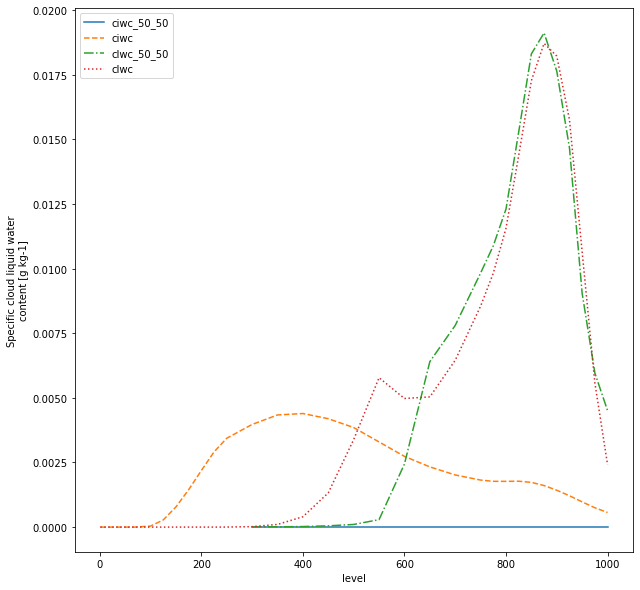

In [44]:
fig, axsm = plt.subplots( 1, 1, figsize=[10, 10], )

# ds_era.ciwc.mean(('time','latitude', 'longitude'),keep_attrs=True).plot(ax=axsm)
# ds_era.clwc.mean(('time','latitude', 'longitude'),keep_attrs=True).plot(ax=axsm)

ds_era['ciwc_50_50'].mean(('time','latitude', 'longitude'),keep_attrs=True, skipna=True).plot(ax=axsm, linestyle = '-', label='ciwc_50_50')
ds_era['ciwc'].mean(('time','latitude', 'longitude'),keep_attrs=True, skipna=True).plot(ax=axsm, linestyle = '--', label='ciwc')
ds_era['clwc_50_50'].mean(('time','latitude', 'longitude'),keep_attrs=True, skipna=True).plot(ax=axsm, linestyle = '-.', label='clwc_50_50')
ds_era['clwc'].mean(('time','latitude', 'longitude'),keep_attrs=True, skipna=True).plot(ax=axsm, linestyle =':',label='clwc')

axsm.legend(
        loc="upper left",
        # bbox_to_anchor=(1.0, 1),
        # fontsize="small",
        fancybox=True,
    )

In [14]:
# 4.1. P(percent_iwc == 50% and percent_lwc == 50%)
ds_era['P_50_50'] = ds_era['pressure'].where(filter_ciwc_clwc)
# 4.2. T(percent_iwc == 50% and percent_lwc == 50%)
ds_era['t_50_50'] =  ds_era['t'].where(filter_ciwc_clwc)
# 4.3. IWC(percent_iwc == 50% and percent_lwc == 50%)
ds_era['ciwc_50_50'] = ds_era['ciwc'].where(filter_ciwc_clwc) 
# 4.4. LWC(percent_iwc == 50% and percent_lwc == 50%)
ds_era['clwc_50_50'] = ds_era['clwc'].where(filter_ciwc_clwc) 
# 4.5 cswc(percent_iwc == 50% and percent_lwc == 50%)
ds_era['cswc_50_50'] = ds_era['cswc'].where(filter_ciwc_clwc) 
# 4.6. sf(percent_iwc == 50% and percent_lwc == 50%)
ds_era['sf_50_50'] = ds_era['sf'].where(filter_ciwc_clwc)
ds_era['sf_50_50'] = ds_era['sf_50_50'].isel(level = 0)
# 4.7. tp(percent_iwc == 50% and percent_lwc == 50%)
ds_era['tp_50_50'] = ds_era['tp'].where(filter_ciwc_clwc) 
ds_era['tp_50_50'] = ds_era['tp_50_50'].isel(level = 0)

In [16]:
ds_era['sf_50_50'].mean('time', keep_attrs=True)

<xarray.DataArray 'sf_50_50' (latitude: 721, longitude: 1440)>
dask.array<mean_agg-aggregate, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    units:      mm day-1
    long_name:  Snowfall

## Regrid ERA5 data to common NorESM2-MM grid <a id='regrid_hz'></a>

We want to conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) for the CMIP6 models in comparison to ERA5. 

The ERA5 data has a nominal resolution of 0.25 deg and has to be regridded to the same horizontal resolution as the NorESM2-MM. Hence we will make use of the python package `xesmf` and [decreasing resolution](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html#Decreasing-resolution), [Limitations and warnings](https://xesmf.readthedocs.io/en/latest/notebooks/Masking.html?highlight=conservative#Limitations-and-warnings).  

$\rightarrow$ Define NorESM2-MM as the reference grid `ds_out`.

Save all variables in one file and each variable to a `netcdf` datasets between 1985 an 2014, locally.

> **_NOTE:_** This can take a while, so be patient

In [ ]:
# Read in the output grid from NorESM
cmip_file = '/scratch/franzihe/input/cmip6_hist/1deg/grid_NorESM2-MM.nc'
ds_out = xr.open_dataset(cmip_file)

# select where data should be saved
filename = 'all_Amon_1deg_{}01_{}12.nc'.format(starty, endy)
era_file_out = era_out + '/Amon/' + filename
files = glob(era_file_out)

counter = 0

# Regrid data
ds_in_regrid = fct.regrid_data(ds_era, ds_out)

# Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')

if era_file_out in files:
    print('{} is downloaded'.format(era_file_out))
    counter += 1
    print('Have regridded in total: {:} files'.format(str(counter))) 
else: # Save to netcdf file
    ds_in_regrid.to_netcdf(era_file_out)
    print('file written: {}'.format(era_file_out))

In [ ]:
counter = 0

for var_id in variable_id:
    # select where data should be saved
    filename = '{}_Amon_1deg_{}01_{}12.nc'.format(var_id, starty, endy)
    era_file_out = era_out + '/Amon/' + filename
    files = glob(era_file_out)
    
    if era_file_out in files:
        print('{} is downloaded'.format(era_file_out))
        counter += 1
        print('Have regridded in total: {:} files'.format(str(counter))) 
    else: # Save to netcdf file
        ds_in_regrid[var_id].to_netcdf(era_file_out)
        print('file written: {}'.format(era_file_out))

# Create seasonal mean/spread of all regridded ERA5

...and plot seasonal mean of each individual model

In [ ]:
for var_id in variable_id:
    ds_era[var_id+'_season_mean'] = ds_era[var_id].groupby('time.season').mean('time', keep_attrs = True)

    ds_era[var_id+'_season_std'] = ds_era[var_id].groupby('time.season').std('time', keep_attrs = True)

In [ ]:
for var_id in variable_id:
    if var_id == 'sf':
        label='Snowfall (mm$\,$day$^{-1}$)'
        vmin = 0
        vmax = 2.5
        levels = 25
        add_colorbar=False
        vmin_std = vmin
        vmax_std= 0.6
    if var_id == 'tp':  
        label='Total precipitation (mm$\,$day$^{-1}$)' 
        vmin = 0
        vmax=9
        levels = 90
        add_colorbar=False
        vmin_std =vmin
        vmax_std = 2.4  
    if var_id == 'tciw':
        label='Ice Water Path (g$\,$m$^{-2}$)'
        vmin = 0
        vmax=100
        levels = 25
        add_colorbar = False
        vmin_std =vmin
        vmax_std = 20
    if var_id == 'tclw':
        label='Liquid Water Path (g$\,$m$^{-2}$)'
        vmin = 0
        vmax=100
        levels = 25
        add_colorbar = False
        vmin_std =vmin
        vmax_std = 20
    if var_id == '2t':
        label='2-m temperature (K)'
        vmin = 246
        vmax=300
        levels = 40
        add_colorbar = False
        vmin_std = 0
        vmax_std=6

    # Plot seasonal mean
    fig, axs, im = fct.plt_spatial_seasonal_mean(ds_era[var_id+'_season_mean'], vmin, vmax, levels, add_colorbar=False, title='ERA5 - high resolution (1985 - 2014)')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
    cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
    cb.set_label(label='MEAN - {}'.format(label), weight='bold')

    plt.tight_layout()

    # save figure to png
    figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/ERA5/'
    figname = '{}_season_1deg_{}_{}.png'.format(var_id, starty, endy)
    plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

    # Plot seasonal mean and std
    fig, axs, im = fct.plt_spatial_seasonal_mean(ds_era[var_id+'_season_mean'], vmin, vmax, levels, add_colorbar=False, title='ERA5 - high resolution (1985 - 2014)')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
    cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
    cb.set_label(label='MEAN - {}'.format(label), weight='bold')

    for ax, i in zip(axs, ds_era[var_id+'_season_std'].season):
        sm = ds_era[var_id+'_season_std'].sel(season=i).plot.contour(ax=ax, transform=ccrs.PlateCarree(), 
                                                                        robust=True,
                                                                        vmin = vmin_std, vmax = vmax_std,
                                                                        levels = 6,
                                                                        cmap=cm.lajolla,
                                                                        add_colorbar=False)
        
    cbar_ax = fig.add_axes([1.10, 0.15, 0.025, 0.7])
    sb = fig.colorbar(sm, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
    sb.set_label(label='STD - {}'.format(label), weight='bold')


    plt.tight_layout()


Find liquid, ice only, mixed phase cloud. Plot histogram of observed snowfall amounts.

FH  11:04 AM
Ok. There is something I don't understand.
You have this in line 165: P_idx=sum(P>100,1)>0;%find hours where seeder feeder might be happening What is the P>100? Pressure level?
RD  11:38 AM
hmmm i dont remember. Ill have a look in a bit
FH  11:39 AM
sure :smile:
RD  1:34 PM
okay so i just checked
1:34
that tells me if there is a true difference between cloud layers
1:35
so basically the T change will go from 0 (where there is no ice cloud) to the T of the cloud
FH  1:36 PM
true difference between the temperatures in the cloud layers?!
RD  1:36 PM
so it makes sure that the code is not tricked by local minimums in T but that there is truly an IWC free layer
1:37
ya so its to avoid situations where you have
250|
245
248
1:37
showing up as a local minimum and therefore it thinks that is a cloud free layer
1:39
it was a way to retain the cloud temperatures and find the cloud free situations
1:40
maybe not the best way but it was an easy way i think
FH  1:44 PM
Ok. I have to think a little about it. So you find the local minimum of the temperature and check at the same time if there is ice?
What I also don't understand is what you do in the next line. P_idx=sum(P>100,1)>0;%find hours where seeder feeder might be happening
RD  1:46 PM
ya so that just finds the profiles where there is seeder feeder based on the gaps in the iwc
1:47
so if the T multiplied by whether there is iwc or not (1 or 0)
1:47
so if the T of this multiplication has points where the change is greater than 100, it identifies it as a profile with seeder feeder
1:49
because in each .nc file there tons of 3 hourly profiles
1:49
so this is a quick way to filter out the ones with seeder-feeder and without
FH  1:49 PM
Got it, I think. I started doing it just with my data. But if everything goes well we can just use the function for the seeder-feeder paper
New
RD  1:50 PM
you cant just use whether there is ice or not (1 or 0) because the diff will mess things up
1:50
you will go from 0 to 1 when the cloud starts and then back to 0 then back 1 at cloud top
1:50
so this was a way to work around that